# Programmatic Visualization

### 01 - Image plotting and automated contrast scaling

Colin Ophus - 2024 Dec 28

This tutorial demonstrates how to write a function which will automatically scale image contrast.

Packages used
- numpy (handle numerical arrays)
- matplotlib (most common python plotting library)
- h5py (read and write hdf5 files)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import gdown

# Get Test Images

In [2]:
# Download images archive to colab.
gdown.download(
  #url = 'https://drive.google.com/file/d/1bPJSuXmu8XduEXOPbVENlq16JHwjzvzf',
  id = '1bPJSuXmu8XduEXOPbVENlq16JHwjzvzf',
  output = '/content/temp.mat'
)

Downloading...
From: https://drive.google.com/uc?id=1bPJSuXmu8XduEXOPbVENlq16JHwjzvzf
To: /content/temp.mat
100%|██████████| 96.1M/96.1M [00:01<00:00, 65.6MB/s]


'/content/temp.mat'

In [3]:
# load images archive (hdf5 matlab format), and combine them into a python list
f = h5py.File('/content/temp.mat','r')
stack = [
    f['image01_UO2_01'][:],
    f['image01_UO2_02'][:],
    f['image02_amor_diff'][:],
    f['image03_diff'][:],
    f['image04_pillar'][:],
    f['image05_rings01'][:],
    f['image05_rings02'][:],
    f['image05_rings03'][:],
    f['image06_gold'][:],
    f['image07_diff01'][:],
    f['image08_CBED01'][:],
    f['image08_CBED02'][:],
    f['image08_CBED03'][:],
    f['image08_CBED04'][:],
    f['image08_CBED05'][:],
    f['image09_Pt'][:],
    f['image10_align01'][:],
    f['image10_align02'][:],
    # f['image10_align03'][:],      # we'll skip this image to import only 18 images total
]

In [5]:
# If you want to peek inside the file, you can uncomment this line:
# f.keys()

In [12]:
# Lets take a look at the image size in pixels (image extent) for the different images
print(stack[3].shape)

(512, 512)


In [13]:
# Next lets look at some of the image arrays, specifically the first 5x5 values.
# Note the stacking of index array operators [ ]
stack[5][0:5,0:3]

array([[  6.8427434,  -2.26804  , -82.25366  ],
       [ 66.741234 , -45.83441  ,  37.146408 ],
       [-12.573513 ,  81.12806  , -10.067259 ],
       [ 40.35714  ,  15.836044 ,  75.35574  ],
       [ -1.3147609, -19.730997 ,  49.542004 ]], dtype=float32)

# Plot single and multiple images

Looking at the numerical values is not very informative!
Because these are image arrays, we should plot them as images.
One of the simplest methods for plotting images in python is matplotlib's imshow() function.

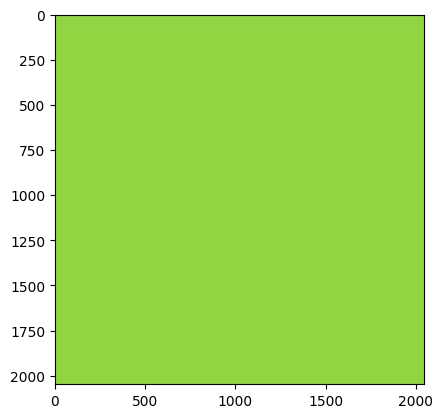

In [21]:
# Try different images!
# Why do images 0,1,2,3,4,8 look ok, but images 5,6,7 look bad?

plt.imshow(
    stack[5],
)

One of the most useful features in matplotlib is the ability to plot multiple figures at once.

This can be done in several ways, including the subplot() function.


In [33]:
print(
    np.min(stack[0]),
    np.max(stack[0]),
)


118882 2067707


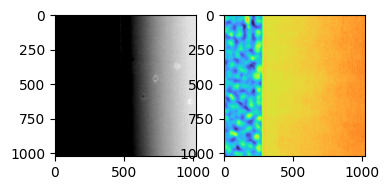

In [38]:
# Try changing the colormaps, the intensity plotting range, etc. in imshow().
fig,ax = plt.subplots(
    1,
    2,
    figsize = (4,4),
)
ax[0].imshow(
    stack[0],
    cmap = 'gray',
    vmin = 1.5e6,
    vmax = 2e6,
    )
ax[1].imshow(
    stack[1],
    cmap = 'turbo',
)
# ax[2].imshow(stack[2])

"fig" is the figure handle, while "ax" is the axes handle.  Note that there is only one fig objects, but two ax objects.

We can use the fig handle to easily save the figure in vector + raster format - vector for the image axes and labels, raster (i.e. bitmap) for the images themselves.

In [39]:
# save the figure
fig.savefig('test figure.pdf')

### Exercise 1 - can you plot all 18 images in the same figure?

Make sure to generalize the function so that it can plot any number of rows and columns.

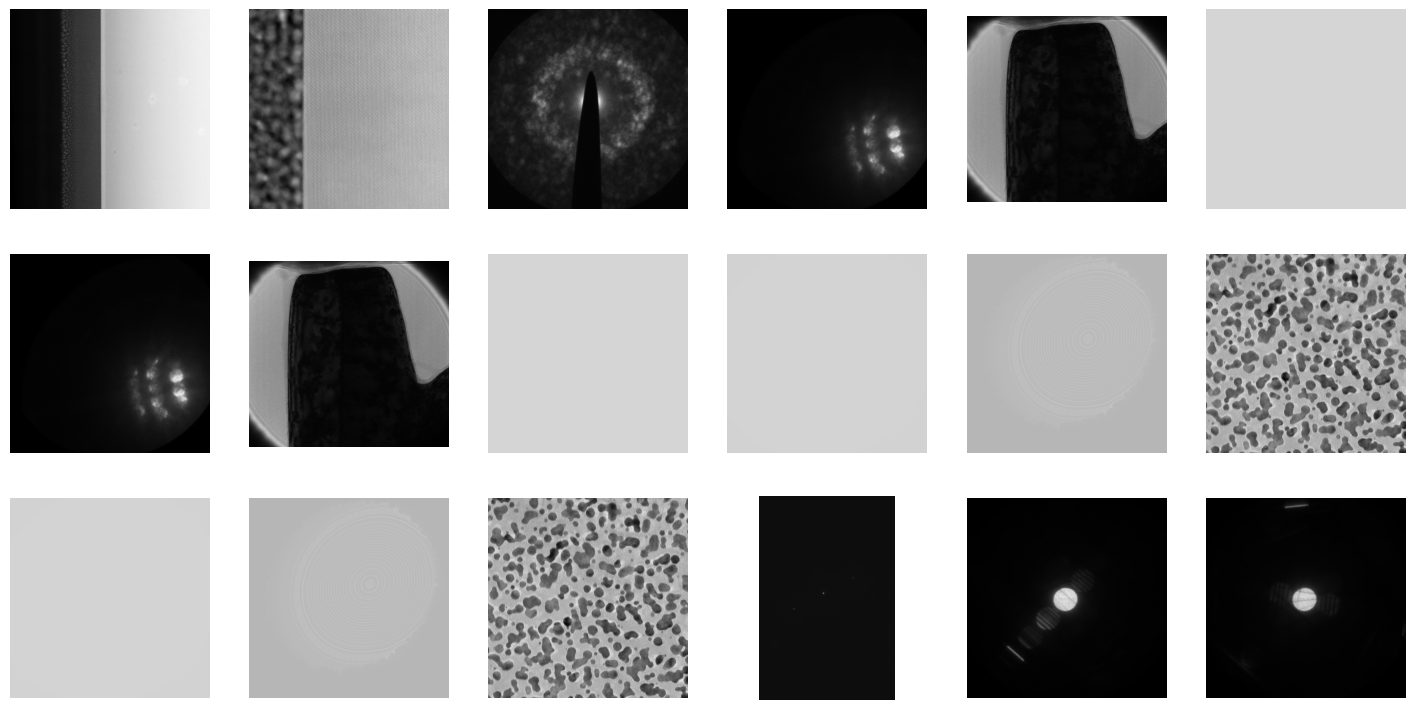

In [ ]:
# Answer 1



# Automatic contrast scaling

As we saw above, many scientific images can't be plotted from the mininum to the maximum value (i.e. setting the darkest pixel to black, and brightest pixel to white). This could be due to a single bright or dark pixel, or just a highly asymmetric intensity distribution.

So what can we do about it?  There are multiple solutions, but the easiest and most robust is histogram image scaling. For example, we could set the black value to the 2% darkest pixel, and the white value to the 2% brightest pixel. This will slightly saturate the colors on both the low (black) and high (white) end, but the benefit is robust contrast scaling.

To see howthis works, lets first look at the image and histogram of an image with "good" and "bad" contrast.

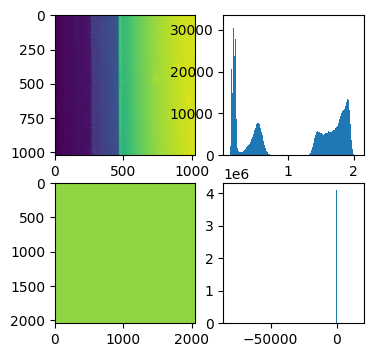

In [40]:
# Note that .ravel() changes the array shape from 2D to 1D, i.e.
# if the image has a shape (Nx,Ny), then image.ravel() has a shape (Nx*Ny,)
inds = (0,5)

fig,ax = plt.subplots(
    2,2,
    figsize=(4,4),
)
# First image
ax[0,0].imshow(stack[inds[0]])
ax[0,1].hist(
    stack[inds[0]].ravel(),
    256,
)
# Second image
ax[1,0].imshow(stack[inds[1]])
ax[1,1].hist(
    stack[inds[1]].ravel(),
    256,
)
plt.show()

So what is going on with image 5?  The histogram looks like a single spike, and the x axis reaches far into negative values. The probably cause is a minor of negative values, perhaps due to dead pixels.

Let's look at the sorted intensity values in this image, perhaps every 100 000'th value.

In [41]:
# Note that when indexing in a numpy array, we use [start:stop:step].
# We can also skip the start and stop values, in which case numpy
# will assume we mean the first and last value.
# Thus [0:-1:100000] becomes [::100000].
print(
    np.sort(
        stack[5].ravel()
    )[::100000]
)

[-8.0813156e+04 -3.8257282e+01 -9.9707127e+00  1.2988280e+01
  3.4436573e+01  5.3313263e+01  6.8342407e+01  8.0158501e+01
  8.9794785e+01  9.7936699e+01  1.0505577e+02  1.1149965e+02
  1.1737770e+02  1.2285199e+02  1.2803600e+02  1.3297745e+02
  1.3773108e+02  1.4233611e+02  1.4683167e+02  1.5122264e+02
  1.5555511e+02  1.5982387e+02  1.6405475e+02  1.6826192e+02
  1.7248125e+02  1.7672893e+02  1.8100694e+02  1.8533409e+02
  1.8974020e+02  1.9422159e+02  1.9883565e+02  2.0359315e+02
  2.0854886e+02  2.1374623e+02  2.1925114e+02  2.2514001e+02
  2.3161578e+02  2.3877975e+02  2.4704741e+02  2.5692056e+02
  2.6990506e+02  2.9014072e+02]


Note how most of these values are positive, in the range of 0 to 300. However the negative values are extremely negative, almost as low as -100 000. This explains the highly asymmetric histogram we observed above.

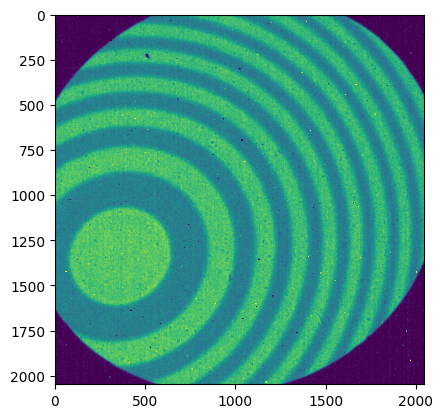

In [42]:
# Let's plot image 5 scaling the intensity range manually.
fig,ax = plt.subplots()
ax.imshow(
    stack[5],
    vmin = 0,
    vmax = 300,
)

Much better!  But here we had to specify the intensity ranges manually.  Is there a better way?  

Several solutions exist - here we will implemented the histogram scaling mentioned above. The general steps are:
1 - sort the intensity values of the image
2 - choose reasonable min and max values from the histogram to use for the black and white values.
3 - plot the image with vmin and vmax set to the automatically chosen values.

We will implement image histogram scaling as a python function, to make it easy to apply to multiple images.



In [46]:
# First, let's get the sorted intensity values
int_vals_sort = np.sort(stack[5].ravel())

In [47]:
# Next lets choose our plotting cut off values, say at 2% (2% darkest) and 98% (2% brightest).
# We then need to find the index values of the intensity values corresponding to these cutoffs.
int_range = (0.02, 0.98)

inds = (
    np.round(stack[5].size * int_range[0]).astype('int'),
    np.round(stack[5].size * int_range[1]).astype('int'),
)
print(inds)

(83886, 4110418)


In [48]:
# Finally we can find the intensity values themselves corresponding to our 2% and 98% cutoffs.
int_vals = (
    int_vals_sort[inds[0]],
    int_vals_sort[inds[1]],
)
print(int_vals)

(-44.16102, 293.21713)


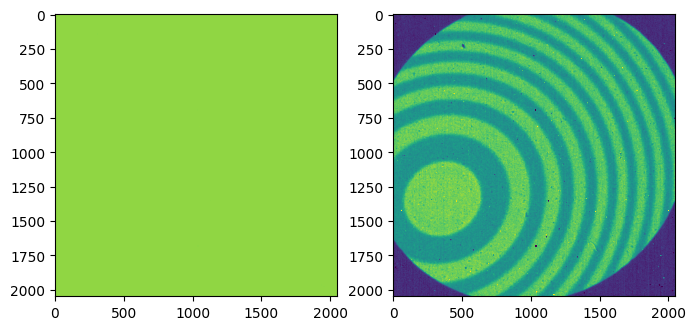

In [49]:
# Let's plot image 5 with and without these intensity cutoffs
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(
    stack[5],
)
ax[1].imshow(
    stack[5],
    vmin = int_vals[0],
    vmax = int_vals[1],
)
plt.show()

Voila!  We have a method to automatically scale intensity values.

Let's make this method more useful by writing a function to enact it.

In [51]:
def plot_image(
  im_array,
  vmin = 0.02,
  vmax = 0.98,
  figsize = (4,4),
  cmap = 'gray',
  return_scaled_im = False,
  ):

  # find intensity ranges
  int_vals = np.sort(im_array.ravel())
  ind0 = np.round(im_array.size * vmin).astype('int')
  ind1 = np.round(im_array.size * vmax).astype('int')
  vmin_absolute = int_vals[ind0]
  vmax_absolute = int_vals[ind1]

  # plot image
  fig,ax = plt.subplots(
      figsize = figsize,
  )
  ax.imshow(
      im_array,
      vmin = vmin_absolute,
      vmax = vmax_absolute,
      cmap = cmap,
  )
  # plotting appearance
  ax.axis('off')

  # if needed, calculate the scaled output array and return it




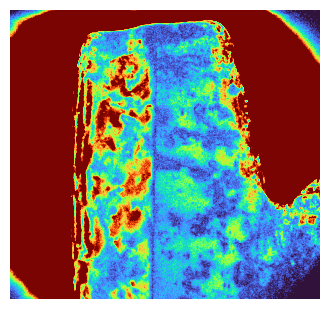

In [60]:
# Lets try our function out!
plot_image(
  stack[4],
  vmin = 0.02,
  vmax = 0.60,
  cmap = 'turbo',
)

Our function works pretty well - but can you find edge cases where the function fails?  If so, can you fix them?

In [ ]:
# scratch space


### Exercise 2 - Create a function which implements automatic histogram scaling for multiple images using subplot().

In [ ]:
# Answer 2


# Fourier image filtering

Often our scientific images are quite noisy, or we need to scale the local mean value for better visualization.

Filtering your images for clarity is absolutely ok - but when writing papers, please make sure to describe all of your filtering steps and include the raw data in supplementary materials or a public repository!

In this section, we will create a function which performs low pass filtering, high pass filtering, or both.  We will also include power law scaling of the output, which can help when plotting signals with orders of magnitude intensity differences in different regions of the images.

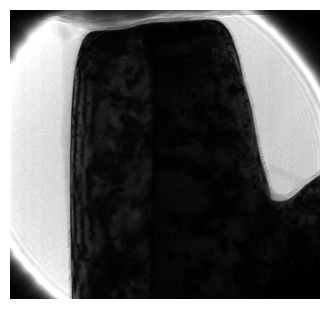

In [ ]:
# This is an example of an image where high pass filtering can should the full FOV.
plot_image(
    stack[4],
    # vmax = 0.6,
)

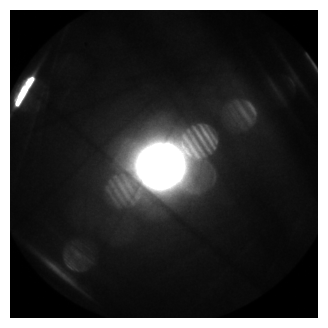

In [ ]:
# This is an example of an image where power law scaling can help visualize all features.
plot_image(
    stack[12],
    # np.maximum(stack[12],0)**0.5,
    # cmap = 'turbo',
    # vmin = 0.14,
)

So what is high or low pass filtering?  How do we implement it?

High pass filtering means we "pass" only spatial frequencies above some cutoff.  Low pass filtering means we "pass" only spatial frequencies below some cutoff.

For both of these filter types, we need to specify how "steep" the cutoff is (we will use a Butterworth Filter shape) and we will implement both by using Fourier transforms.  Applying a Fourier filter has three steps:

- Take the FFT of our image.
- Multiply the image FFT by our filter.
- Take the inverse FFT.

We will also be using Fourier coordinates, specifically with units of 1/pixels. By the Nyquist theorem, the maximum spatial frequency will be 1/(2*pixels).  So a low pass filter with a cutoff of >1.0 will do essentially nothing.

In [ ]:
# Function which power law scales, and then Fourier filters an image.
# We will also add an option to plot the FFT intensity and overlay the filters.

def filter_image(
    im_array,
    im_power_scaling = 1.0,
    q_cutoff_low = None,
    q_power_low = 2.0,
    q_cutoff_high = None,
    q_power_high = 2.0,
    plot_filter = False,
    ):

    # Fourier coordinates
    qx = np.fft.fftfreq(im_array.shape[0], d = 1.0)
    qy = np.fft.fftfreq(im_array.shape[1], d = 1.0)
    q2 = qx[:,None]**2 + qy[None,:]**2

    # Define the filter array
    if q_cutoff_low is None:
        q_filt = np.ones(im_array.shape,dtype='float')
    else:
        q_filt = 1 / (
            1 + (q2**(q_power_low/2.0)) \
            / ((q_cutoff_low)**(q_power_low))
        )
    if q_cutoff_high is not None:
        q_filt *= (1 - \
            1 / (
                1 + (q2**(q_power_high/2.0)) \
                / ((q_cutoff_high)**(q_power_high))
            )
        )

    # power law scaling of the image
    if im_power_scaling != 1.0:
        im_array = np.maximum(im_array.astype('float'),0)**im_power_scaling
    else:
        im_array = im_array.astype('float')

    # Take image FFT
    im_fft = np.fft.fft2(im_array)

    # Apply filter
    im_fft *= q_filt

    # Take inverse FFT of image
    im_filter = np.real(
        np.fft.ifft2(im_fft)
    )



    # Return the filtered image
    return im_filter


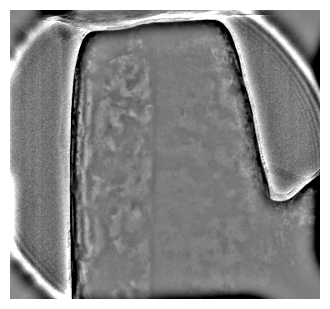

In [ ]:
# Testing high pass filtering
plot_image(
  filter_image(
    stack[4],
    im_power_scaling = 1.0,
    # q_cutoff_low = 0.1,
    # q_power_low = 2.0,
    q_cutoff_high = 0.01,
    q_power_high = 4.0,
    plot_filter = False,
  )
)

High pass filtering works - but can you spot the artifact we have introduced?

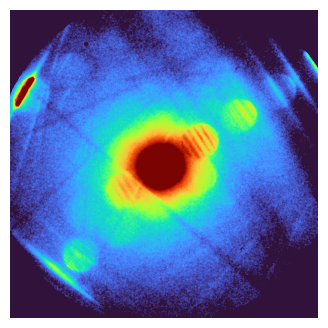

In [ ]:
# Testing high pass filtering
plot_image(
  filter_image(
    stack[12],
    im_power_scaling = 0.25,
    # q_cutoff_low = 0.1,
    # q_power_low = 2.0,
    # q_cutoff_high = 0.01,
    # q_power_high = 4.0,
    plot_filter = False,
  ),
  vmin = 0.2,
  cmap = 'turbo',
)

### Exercise 3 - Create a function to apply other types of filtering to an image.

Possbilities include:

- 2D median with scipy.signal.medfilt2D()
- 2D Gaussian Laplace with scipy.ndimage.gaussian_laplace()
- Image rotation with scipy.ndimage.rotate()
- Anything else you can imagine!


In [ ]:
# Answer 3
